In [26]:
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

## Load the data

In [ ]:
df = pd.read_parquet('../data/yellow_tripdata_2023-01.parquet')

In [5]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           int64         
 8   DOLocationID           int64         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

In [7]:
print(f"There are {df.shape[1]} columns")

There are 19 columns


## Computing duration

In [8]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
df['duration'] = df.duration.apply(lambda td: td.total_seconds() / 60)

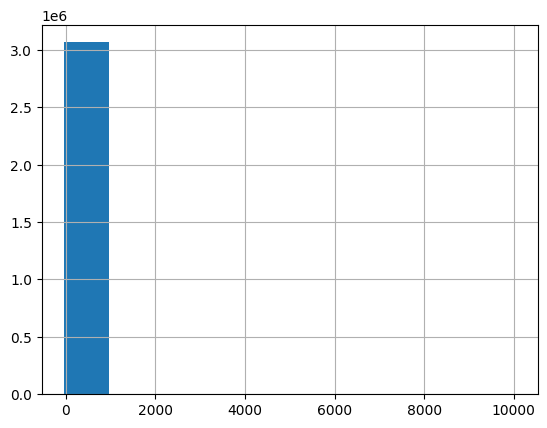

In [9]:
df['duration'].hist()
plt.show()

In [10]:
df['duration'].std()

42.594351241920904

In [11]:
df['duration'].describe().round(2)

,duration
count,3066766.00
mean,15.67
std,42.59
min,-29.20
25%,7.12
50%,11.52
75%,18.30
max,10029.18


In [15]:
df['duration'].describe(percentiles=[0.01, 0.05, 0.1, 0.98, 0.99, 0.999]).round(2)

,duration
count,3066766.00
mean,15.67
std,42.59
min,-29.20
1%,0.78
5%,3.30
10%,4.48
50%,11.52
98%,48.73
99%,57.25


## Dropping outliers in `duration`

In [16]:
((df.duration >=1) & (df.duration <= 60)).mean()

np.float64(0.9812202822125979)

In [17]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [18]:
df.shape

(3009173, 20)

## One-hot encoding for `pickup` and `dropoff` location IDs

In [19]:
categorical = ['PULocationID', 'DOLocationID']
df[categorical] = df[categorical].astype(str)

In [24]:
train_dict = df[categorical].to_dict(orient='records')
dv = DictVectorizer()

X_train = dv.fit_transform(train_dict)

In [25]:
X_train.shape

(3009173, 515)

## Training a model

In [28]:
target = 'duration'
y_train = df[target].values

lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

7.649261932106969

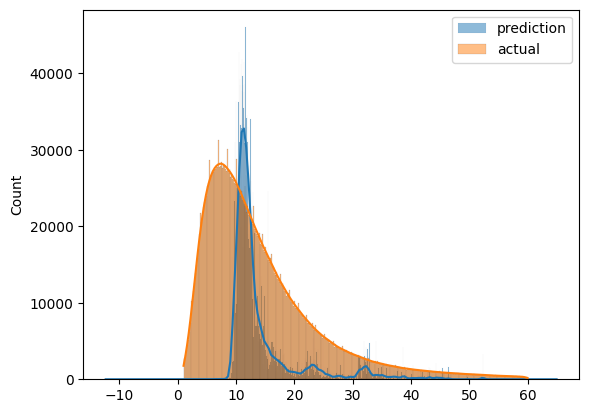

In [30]:
sns.histplot(y_pred, kde=True, label='prediction')
sns.histplot(y_train, kde=True, label='actual')

plt.legend()
plt.show()

## Evaluating the model

In [34]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df

In [ ]:
df_val = read_dataframe('yellow_tripdata_2023-02.parquet')

In [36]:
val_dict = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [37]:
X_val.shape

(2855951, 515)

In [38]:
y_val = df_val[target].values

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.811818743246608

## Saving the model

In [ ]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)